# Forecasting one step ahead with benchmarking

In the previous notebook, we used a train-test split strategy to forecast pollutant concentrations for the next hour. We trained the feature engineering stages and Lasso regression on the train set before evaluating the results on the test set.

Here, we'll repeat the procedure, but this time we'll include a benchmarking step that uses expanding windows to get a measure of performance on the training set as well. 


## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import (
    CyclicalFeatures,
    MathFeatures,
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# We carry out all data preparation steps from the
# notebook in section 2 within a function.

def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [3]:
# Load data.

data = load_data()

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Our feature engineering class

In [4]:
class SeasonalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's
        # concentration per hour.

        # We make a copy of the dataframe
        # not to over-write the user's data.
        X = X.copy()

        # Calculate mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + "_season" for v in self.variables]

        # Reset index
        self.seasonal_ = self.seasonal_.reset_index()

        return self

    def transform(self, X):

        # Add the seasonal component to the
        # dataset to transform.

        X = X.copy()

        # Store the datetime index (it is lost in merge)
        index = X.index

        # Add the seasonal feature.
        X = X.merge(self.seasonal_, on=self.season_var, how="left")

        # Restore the datetime index to the df
        X.index = index

        # Drop input variable
        X = X.drop(self.variables, axis=1)

        return X

# Feature engineering steps

The same pipeline from the previous notebook.

In [5]:
# Datetime features

dtf = DatetimeFeatures(

    # the input dt variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [6]:
# Lag features.

lagf = LagFeatures(
    variables="CO_sensor",  # the input variable
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [7]:
# Window features

winf = WindowFeatures(
    variables="CO_sensor",  # the input variable
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [8]:
# Feature combination

combine = MathFeatures(
    
    # the variables to combine
    variables=["CO_sensor_lag_1H", "CO_sensor_lag_24H"],
    
    # we indicate we want the average
    func=["mean"],
    
    # the name of the new feature
    new_variables_names=["CO_lag_ave"],
    
    # what to do if the variables have NA
    missing_values="ignore",
)

In [9]:
# Periodic features

cyclicf = CyclicalFeatures(
    
    # The features we want to transform.
    variables=["month", "hour"],
    
    # Whether to drop the original features.
    drop_original=False,
)

In [10]:
# Drop missing data
imputer = DropMissingData()

In [11]:
# Seasonal feature

seasonf = SeasonalTransformer(
    # the seasonal variable
    season_var="hour",
    # the time series
    variables=["CO_sensor"],
)

# Feature engineering pipeline

In [12]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("combine", combine),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("seasonal", seasonf),
    ]
)

# Lasso regression

We set up the model.

In [13]:
# Lasso regression

lasso = Lasso(random_state=0)

# Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need to add the 24 hours prior to the first point in the test set to be able to create the lag and window features.

In [14]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp(
    "2005-03-04") - pd.offsets.Hour(24)]["CO_sensor"]

# Back-testing with expanding window

Now, we will train the model over expanding windows utilizing the training set to obtain a measure of performance over the train set.

We will train the model over 4 expanding windows of the training set (green in the image), and then test its performance on a portion of the data one month ahead (blue in the image).


<img src='../images/backtesting.png' width="600" height="600">


In [15]:
# Capture first day on train set.

start = X_train.iloc[0].name
start

Timestamp('2004-04-04 00:00:00')

In [16]:
# Capture last day on train set.

end = X_train.iloc[-1].name
end

Timestamp('2005-03-03 23:00:00')

In [17]:
# Create 4 cut-off times for 4-fold cross-validation.

# Periods needs to be 6, because date_range automatically
# adds the first and last date of the data, which we don't need.

# Note: the parameter `inclusive` is available only in pandas version 1.4
# and above.

cutoffs = pd.date_range(start=start, end=end, periods=6, inclusive="neither")

cutoffs

DatetimeIndex(['2004-06-09 19:00:00', '2004-08-15 14:00:00',
               '2004-10-21 09:00:00', '2004-12-27 04:00:00'],
              dtype='datetime64[ns]', freq=None)

In [18]:
# In this list, we will collect the RMSE for each fold.
rmse_ls = []

for date in cutoffs:

    # Split the data:
    
    # Here we perform the expanding window:
    
    # All data prior to a certain date: training fold.
    X_train_fold = X_train[X_train.index < date]
    y_train_fold = X_train[X_train.index < date]["CO_sensor"]
    
    # Test fold: the following month of data
    # plus 24 hr prior data to create the features:
    X_test_fold = X_train[
        (X_train.index >= date - pd.offsets.Hour(24)) & 
        (X_train.index < date + pd.DateOffset(months=1))
    ]
    
    y_test_fold = X_train[
        (X_train.index >= date - pd.offsets.Hour(24)) & 
        (X_train.index < date + pd.DateOffset(months=1))
    ]["CO_sensor"]
    

    # Using the training fold: train model
    # ====================================
    
    # Fit feature engineering steps and
    # create features afterwards.
    X_train_t = pipe.fit_transform(X_train_fold)

    # Adjust y
    y_train_t = y_train_fold.loc[X_train_t.index]

    # Fit regression model
    lasso.fit(X_train_t, y_train_t)

    # Using testing fold: evaluate model
    # ==================================

    # Create features.
    X_test_t = pipe.transform(X_test_fold)

    # Adjust y.
    y_test_t = y_test_fold.loc[X_test_t.index]

    # Obtain predictions.
    preds = lasso.predict(X_test_t)

    # Determine the RMSE.
    rmse_ = mean_squared_error(
        y_true=y_test_t,
        y_pred=preds,
        squared=False,
    )
    
    # Append the RMSE to our list.
    rmse_ls.append(rmse_)

In [19]:
# Mean performance during cross-validation.

print("rmse: ", np.mean(rmse_ls), "+-", np.std(rmse_ls))

rmse:  89.08709368952115 +- 6.718333759101994


Now we have a measure of the performance with an interval of error. 

To finish, we train the model on the entire training set and evaluate its performance on the hold-out sample. The results should be within the interval of error that we determined above.


# Train final model

In [20]:
# Create the features.

X_train = pipe.fit_transform(X_train)

# Adjust the target.

y_train = y_train.loc[X_train.index]

In [21]:
# Fit the regression.
lasso.fit(X_train, y_train)

Lasso(random_state=0)

In [22]:
# The RMSE in the train set.

mean_squared_error(lasso.predict(X_train_t), y_train_t, squared=False)

93.43695569522737

# Evaluate performance in hold-out sample

In [23]:
# Create features.

X_test_t = pipe.transform(X_test)

# Adjust target.

y_test_t = y_test.loc[X_test_t.index]

In [24]:
# RMSE in test set

mean_squared_error(lasso.predict(X_test_t), y_test_t, squared=False)

92.62517930172112

# Feature importance

Text(0, 0.5, 'Importance')

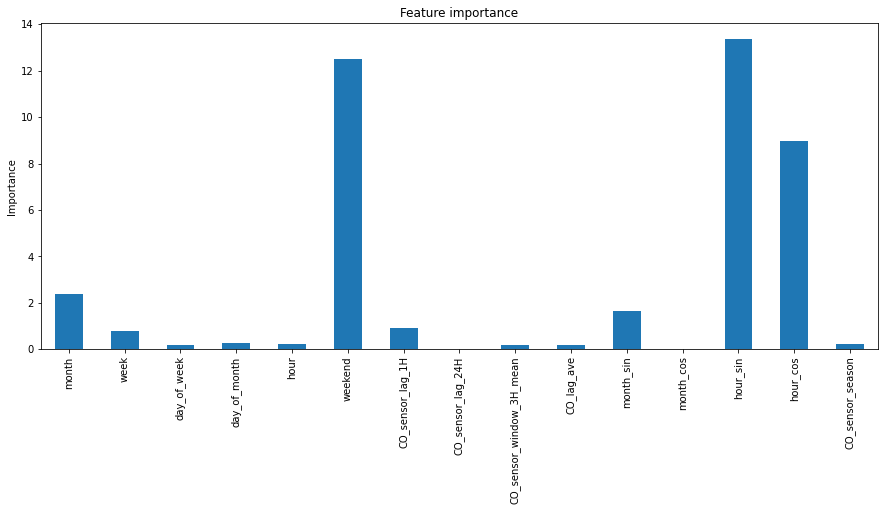

In [25]:
# Let's now plot the feature's importance

# The importance is stored in the estimator.
tmp = pd.Series(np.abs(lasso.coef_))

# Let's add the variable names.
tmp.index = X_train_t.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

The model captures the seasonality: see how many time related features contribute substantially to the prediction output.